                                                Process Event Log Analysis

 STEP 1 — Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

STEP 2 — Load Dataset

In [9]:
df = pd.read_csv("C:/Users/surek/OneDrive/Desktop/process_event_log_dataset.csv")

In [5]:
df

,Case_ID,Activity,Timestamp,Resource
0,1,Order Created,2024-02-10 15:00:00,System
1,1,Order Approved,2024-02-12 03:00:00,Finance Team
2,1,Credit Check,2024-02-13 08:00:00,Finance Team
3,1,Payment Processed,2024-02-13 22:00:00,Manager
4,1,Order Packed,2024-02-14 10:00:00,Manager
...,...,...,...,...
3495,500,Credit Check,2024-01-18 06:00:00,Logistics
3496,500,Payment Processed,2024-01-20 22:00:00,Warehouse
3497,500,Order Packed,2024-01-22 09:00:00,Logistics
3498,500,Order Shipped,2024-01-24 07:00:00,Logistics


In [6]:
df.head()

,Case_ID,Activity,Timestamp,Resource
0,1,Order Created,2024-02-10 15:00:00,System
1,1,Order Approved,2024-02-12 03:00:00,Finance Team
2,1,Credit Check,2024-02-13 08:00:00,Finance Team
3,1,Payment Processed,2024-02-13 22:00:00,Manager
4,1,Order Packed,2024-02-14 10:00:00,Manager


                                            Basic Data Understanding (EDA Start)

In [11]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Case_ID    3500 non-null   int64 
 1   Activity   3500 non-null   object
 2   Timestamp  3500 non-null   object
 3   Resource   3500 non-null   object
dtypes: int64(1), object(3)
memory usage: 109.5+ KB


                                                        Convert Timestamp to datetime

In [12]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])


                                                        Check missing values

In [13]:
df.isnull().sum()


Case_ID      0
Activity     0
Timestamp    0
Resource     0
dtype: int64

                                                            Sort Data Properly

In [15]:
df = df.sort_values(by=["Case_ID", "Timestamp"])
df.head()


,Case_ID,Activity,Timestamp,Resource
0,1,Order Created,2024-02-10 15:00:00,System
1,1,Order Approved,2024-02-12 03:00:00,Finance Team
2,1,Credit Check,2024-02-13 08:00:00,Finance Team
3,1,Payment Processed,2024-02-13 22:00:00,Manager
4,1,Order Packed,2024-02-14 10:00:00,Manager


                                                Calculate Throughput Time (Cycle Time)

In [17]:
throughput = df.groupby("Case_ID")["Timestamp"].agg(["min", "max"])

throughput["Throughput_Hours"] = (
    throughput["max"] - throughput["min"]
).dt.total_seconds() / 3600

throughput.head()


,min,max,Throughput_Hours
Case_ID,,,
1,2024-02-10 15:00:00,2024-02-16 21:00:00,150.0
2,2024-01-15 06:00:00,2024-01-23 13:00:00,199.0
3,2024-01-23 12:00:00,2024-02-02 02:00:00,230.0
4,2024-01-10 01:00:00,2024-01-19 02:00:00,217.0
5,2024-01-26 12:00:00,2024-02-03 06:00:00,186.0


                                                    Average Throughput

In [18]:
throughput["Throughput_Hours"].mean()


np.float64(221.09)

In [19]:
activity_counts = df["Activity"].value_counts()
activity_counts


Activity
Order Created        500
Order Approved       500
Credit Check         500
Payment Processed    500
Order Packed         500
Order Shipped        500
Order Delivered      500
Name: count, dtype: int64

                                            Calculate Time Between Activities

In [20]:
df["Next_Timestamp"] = df.groupby("Case_ID")["Timestamp"].shift(-1)

df["Activity_Duration_Hours"] = (
    df["Next_Timestamp"] - df["Timestamp"]
).dt.total_seconds() / 3600

df.head()


,Case_ID,Activity,Timestamp,Resource,Next_Timestamp,Activity_Duration_Hours
0,1,Order Created,2024-02-10 15:00:00,System,2024-02-12 03:00:00,36.0
1,1,Order Approved,2024-02-12 03:00:00,Finance Team,2024-02-13 08:00:00,29.0
2,1,Credit Check,2024-02-13 08:00:00,Finance Team,2024-02-13 22:00:00,14.0
3,1,Payment Processed,2024-02-13 22:00:00,Manager,2024-02-14 10:00:00,12.0
4,1,Order Packed,2024-02-14 10:00:00,Manager,2024-02-16 17:00:00,55.0


                                                Detect Bottleneck

In [21]:
bottleneck = df.groupby("Activity")["Activity_Duration_Hours"].mean().sort_values(ascending=False)

bottleneck


Activity
Order Packed         37.596
Order Created        37.544
Order Shipped        37.276
Order Approved       36.562
Payment Processed    36.362
Credit Check         35.750
Order Delivered         NaN
Name: Activity_Duration_Hours, dtype: float64

                                        Visualization (Throughput Distribution)

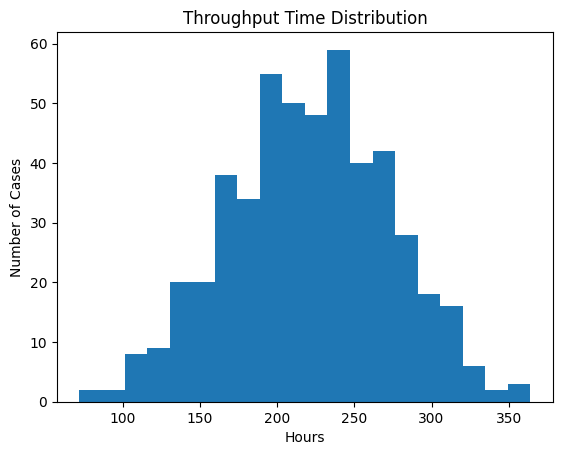

In [23]:
plt.figure()
plt.hist(throughput["Throughput_Hours"], bins=20)
plt.title("Throughput Time Distribution")
plt.xlabel("Hours")
plt.ylabel("Number of Cases")
plt.show()


                                            Resource Performance Analysis

In [24]:
resource_delay = df.groupby("Resource")["Activity_Duration_Hours"].mean().sort_values(ascending=False)

print("Average Delay by Resource:")
print(resource_delay)


Average Delay by Resource:
Resource
Warehouse       38.158363
Manager         37.179903
Finance Team    36.600666
Logistics       36.335987
System          36.054054
Name: Activity_Duration_Hours, dtype: float64


                                            Case-Level Feature Engineering

In [25]:
case_features = df.groupby("Case_ID").agg(
    Total_Activities=("Activity", "count"),
    Avg_Activity_Duration=("Activity_Duration_Hours", "mean"),
    Total_Process_Time=("Timestamp", lambda x: (x.max() - x.min()).total_seconds() / 3600)
).reset_index()

case_features.head()


,Case_ID,Total_Activities,Avg_Activity_Duration,Total_Process_Time
0,1,7,25.000000,150.0
1,2,7,33.166667,199.0
2,3,7,38.333333,230.0
3,4,7,36.166667,217.0
4,5,7,31.000000,186.0


                                        Identify Slow Cases (Anomaly Detection Logic)

In [26]:
threshold = case_features["Total_Process_Time"].mean() + 2 * case_features["Total_Process_Time"].std()

slow_cases = case_features[case_features["Total_Process_Time"] > threshold]

print("Number of Slow Cases:", len(slow_cases))
slow_cases.head()


Number of Slow Cases: 8


,Case_ID,Total_Activities,Avg_Activity_Duration,Total_Process_Time
101,102,7,56.666667,340.0
120,121,7,55.000000,330.0
185,186,7,55.166667,331.0
232,233,7,58.833333,353.0
325,326,7,55.166667,331.0


In [27]:
process_variants = df.groupby("Case_ID")["Activity"].apply(lambda x: " → ".join(x)).reset_index()

variant_counts = process_variants["Activity"].value_counts()

print("Top Process Variants:")
print(variant_counts.head())


Top Process Variants:
Activity
Order Created → Order Approved → Credit Check → Payment Processed → Order Packed → Order Shipped → Order Delivered    500
Name: count, dtype: int64


In [29]:
df.to_csv("cleaned_event_log.csv", index=False)
case_features.to_csv("case_level_features.csv", index=False)
